**Подготовка данных**

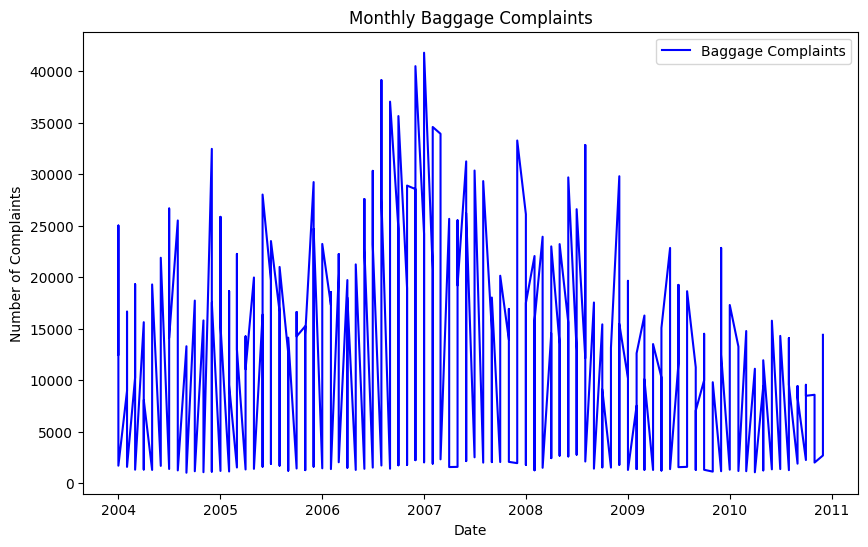

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Преобразуем поля 'Date', 'Month', 'Year' в datetime и устанавливаем его как индекс DataFrame
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))
df = df.set_index('Date')

# Сортируем по индексу
df = df.sort_index()

# Визуализация временного ряда жалоб на багаж
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Baggage'], label='Baggage Complaints', color='blue')
plt.title('Monthly Baggage Complaints')
plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.legend()
plt.show()
# Для упрощения задачи предскажем количество жалоб, используя только этот столбец
data = df[['Baggage']]


**Разделение данных на обучающую и тестовую выборку**

In [45]:
# Разбиение данных на обучающую и тестовую выборки
train_size = int(len(data) * 0.8)
train, test = data[0:train_size], data[train_size:len(data)]
print(len(test))

51


**Прогнозирование временного ряда**

**Метод 1: ARIMA**

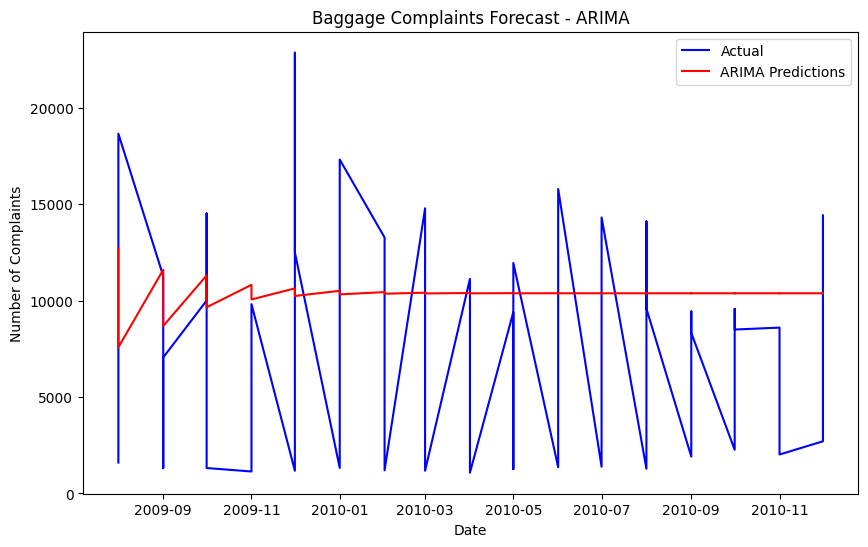

Random Forest MSE: 37407897.51


In [46]:
# Прогнозирование с использованием ARIMA
model_arima = ARIMA(train, order=(5,1,0))
model_arima_fit = model_arima.fit()
predictions_arima = model_arima_fit.forecast(steps=len(test))

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, predictions_arima, label='ARIMA Predictions', color='red')
plt.title('Baggage Complaints Forecast - ARIMA')
plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.legend()
plt.show()

# Оценка качества прогноза
mse_rf = mean_squared_error(test, predictions_arima)
print(f'Random Forest MSE: {mse_rf:.2f}')

**Метод 2: Прогнозирование с использованием Random Forest**

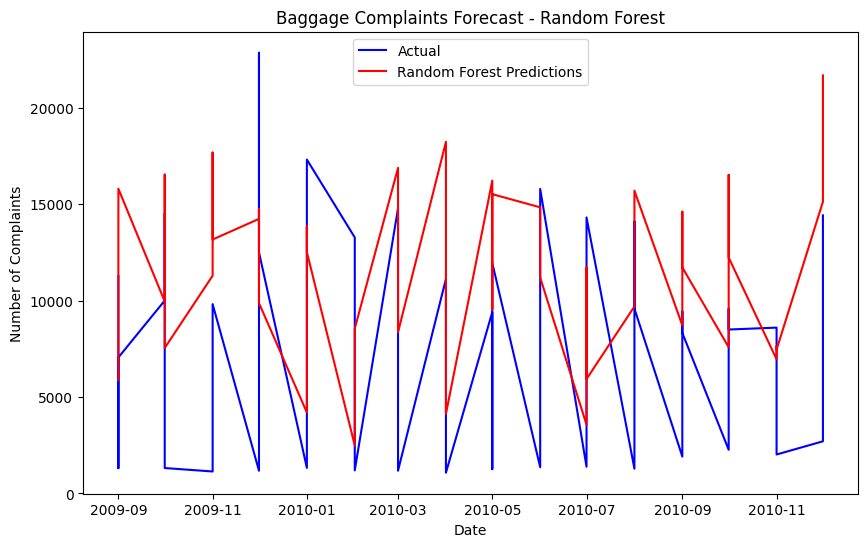

Random Forest MSE: 42158181.49


In [47]:
# Для линейной регрессии преобразуем индекс в числовой формат
from sklearn.ensemble import RandomForestRegressor

# Функция для подготовки данных с лагами
def create_features(df, lag=1):
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df['Baggage'].shift(i)
    df.dropna(inplace=True)  # Удаляем строки с NaN, появившиеся из-за сдвига
    return df

# Применение функции для создания признаков
lag = 3  # Количество лаговых признаков
data_with_lags = create_features(data.copy(), lag=lag)

# Подготовка обучающей и тестовой выборок с учетом лагов
train, test = data_with_lags[0:train_size], data_with_lags[train_size:len(data)]

X_train = train.drop('Baggage', axis=1)
y_train = train['Baggage']
X_test = test.drop('Baggage', axis=1)
y_test = test['Baggage']

# Обучение модели случайного леса
model_rf = RandomForestRegressor(n_estimators=100, random_state=0)
model_rf.fit(X_train, y_train)
predictions_rf = model_rf.predict(X_test)

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(test.index, y_test, label='Actual', color='blue')
plt.plot(test.index, predictions_rf, label='Random Forest Predictions', color='red')
plt.title('Baggage Complaints Forecast - Random Forest')
plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.legend()
plt.show()

# Оценка качества прогноза
mse_rf = mean_squared_error(y_test, predictions_rf)
print(f'Random Forest MSE: {mse_rf:.2f}')
